In [1]:
using NRIRHOPM, FileIO, Images, Plots, Interpolations, Memento; gr()

  likely near /Users/gnimuc/.julia/v0.5/NIfTI/src/NIfTI.jl:88


Plots.GRBackend()

In [2]:
import NRIRHOPM: constrain!

In [3]:
include("draw2.jl")

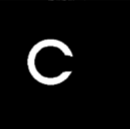

In [4]:
circle = Gray.(load("./ring.png"))

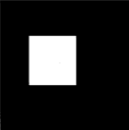

In [5]:
square = Gray.(load("./square.png"))

In [6]:
size(circle), size(square), typeof(circle)

((130,129),(129,130),Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2})

In [7]:
square, circle = restrict(square), restrict(circle); 

In [8]:
fixed, moving = square[1:64,1:64],  circle[1:64,1:64];

In [9]:
function hopm_canonical2(𝐭::AbstractMatrix, 𝐓::BlockedTensor, 𝐌::AbstractMatrix,
                        tol::Real, maxIter::Integer,a
                       )
    e, 𝐯 = hopm_canonical2(reshape(𝐭, length(𝐭)), 𝐓, reshape(𝐌, length(𝐌)), tol, maxIter,a)
    return e, reshape(𝐯, size(𝐭))
end

function hopm_canonical2(𝐭::AbstractMatrix, 𝐓::BlockedTensor, 𝑻::BlockedTensor, 𝐌::AbstractMatrix,
                        tol::Real, maxIter::Integer,a,b
                       )
    e, 𝐯 = hopm_canonical2(reshape(𝐭, length(𝐭)), 𝐓, 𝑻, reshape(𝐌, length(𝐌)), tol, maxIter,a,b)
    return e, reshape(𝐯, size(𝐭))
end

function hopm_canonical2(𝐭::AbstractVector, 𝐓::BlockedTensor, 𝐯::AbstractVector,
    tol::Real, maxIter::Integer, a::Float64
                       )
    𝐯₀ = copy(𝐯)
    normalize!(𝐯₀)
    𝐯ᵢ = 𝐯₀
    i = 0
    while i < maxIter
        i += 1
        𝐯ᵢ₊₁ = 𝐯ᵢ .* 𝐭 + a*(𝐓 ⊙ 𝐯ᵢ)
        normalize!(𝐯ᵢ₊₁)
        if vecnorm(𝐯ᵢ₊₁ - 𝐯ᵢ) < tol
            𝐯ᵢ = 𝐯ᵢ₊₁
            break
        end
        𝐯ᵢ = 𝐯ᵢ₊₁
    end
    logger = get_logger(current_module())
    i == maxIter && warn(logger, "Maximum iterator number is reached, the result might not be convergent.")
    i < maxIter && info(logger, "HOPM converges in $i steps.")
    return 𝐯ᵢ ⋅ (𝐯ᵢ .* 𝐭 + a*(𝐓 ⊙ 𝐯ᵢ)), 𝐯ᵢ
end

function hopm_canonical2(𝐭::AbstractVector, 𝐓::BlockedTensor, 𝑻::BlockedTensor, 𝐯::AbstractVector,
    tol::Real, maxIter::Integer, a::Float64, b::Float64
                       )
    𝐯₀ = copy(𝐯)
    normalize!(𝐯₀)
    𝐯ᵢ = 𝐯₀
    i = 0
    while i < maxIter
        i += 1
        𝐯ᵢ₊₁ = 𝐯ᵢ .* 𝐯ᵢ .* 𝐭 + a*(𝐯ᵢ .* (𝐓 ⊙ 𝐯ᵢ)) + b*(𝑻 ⊙ 𝐯ᵢ)
        normalize!(𝐯ᵢ₊₁)
        if vecnorm(𝐯ᵢ₊₁ - 𝐯ᵢ) < tol
            𝐯ᵢ = 𝐯ᵢ₊₁
            break
        end
        𝐯ᵢ = 𝐯ᵢ₊₁
    end
    logger = get_logger(current_module())
    i == maxIter && warn(logger, "Maximum iterator number is reached, the result might not be convergent.")
    i < maxIter && info(logger, "HOPM converges in $i steps.")
    return 𝐯ᵢ ⋅ (𝐯ᵢ .* 𝐯ᵢ .* 𝐭 + a*(𝐯ᵢ .* (𝐓 ⊙ 𝐯ᵢ)) + b*(𝑻 ⊙ 𝐯ᵢ)), 𝐯ᵢ
end

hopm_canonical2 (generic function with 4 methods)

In [10]:
immutable HOPM2{F<:Function,Tt<:Real,Tm<:Integer} <: AbstractHOPMMethod
    f::F
    tolerance::Tt
    maxIteration::Tm
    a::Float64
end
HOPM2(tolerance, maxIteration,a) = HOPM2(hopm_canonical2, tolerance, maxIteration,a)
HOPM2(; tolerance=1e-5, maxIteration=300,a=1) = HOPM2( tolerance, maxIteration,a)

immutable HOPM3{F<:Function,Tt<:Real,Tm<:Integer} <: AbstractHOPMMethod
    f::F
    tolerance::Tt
    maxIteration::Tm
    a::Float64
    b::Float64
end
HOPM3( tolerance, maxIteration,a,b) = HOPM3(hopm_canonical2,  tolerance, maxIteration,a,b)
HOPM3(; tolerance=1e-5, maxIteration=300,a=1,b=1) = HOPM3( tolerance, maxIteration,a,b)

HOPM3{F<:Function,Tt<:Real,Tm<:Integer}

In [38]:
# displacements = [SVector(i,j) for i in -3:3, j in -3:3]
# displacements2 = [SVector(i,j) for i in -1:1, j in -1:1]
displacetopo = [SVector(i,j) for i in -3:3, j in -3:3]
displacementSet = [displacetopo,displacetopo]#, displacements, displacements2]
gridSet = [(32,32),(32,32)] #,(64,64),(128,128)]
originΔ = vecnorm(moving-fixed)
warpped, d, spec, energy = multilevel(fixed, moving, displacementSet, gridSet, topology=NRIRHOPM.TP2D(), 
α=1, β=0.1, χ=0, method=CanonHOPM(maxIteration=200))
topologyΔ = vecnorm(warpped[end]-fixed)

[ 2017-03-04T12:15:47 | info ]: Start multilevel processing...
[ 2017-03-04T12:15:47 | info ]: Level 1: 
[ 2017-03-04T12:15:47 | info ]: Image Dimension: (64,64)
[ 2017-03-04T12:15:47 | info ]: Grid Dimension: (32,32)
[ 2017-03-04T12:15:47 | info ]: Creating data cost with weight=1: 
[ 2017-03-04T12:15:47 | info ]:   0.325560 seconds (2.89 M allocations: 81.664 MB, 8.34% gc time)
[ 2017-03-04T12:15:47 | info ]: Creating smooth cost with weight=0.1: 
[ 2017-03-04T12:15:47 | info ]:   0.012510 seconds (6.16 k allocations: 449.321 KB)
[ 2017-03-04T12:15:47 | info ]: Optimizing via High Order Power Method: 
[ 2017-03-04T12:15:56 | warn ]: Maximum iterator number is reached, the result might not be convergent.
[ 2017-03-04T12:15:56 | info ]:   8.584511 seconds (7.82 k allocations: 462.374 MB, 0.82% gc time)
[ 2017-03-04T12:15:56 | info ]: Multilevel processing done!


9.385043443472536

In [57]:
displacetopo = [SVector(i,j) for i in -3:3, j in -3:3]
displacementSet = [displacetopo]
gridSet = [(32,32)]
warpped, d, spec, energy = multilevel(fixed, moving, displacementSet, gridSet, topology=NRIRHOPM.TP2D(), 
α=1, β=0.1, χ=0.00001, method=CanonHOPM(maxIteration=20))
topologyΔ = vecnorm(warpped[end]-fixed)

[ 2017-03-04T12:33:09 | info ]: Start multilevel processing...
[ 2017-03-04T12:33:09 | info ]: Level 0: 
[ 2017-03-04T12:33:09 | info ]: Image Dimension: (64,64)
[ 2017-03-04T12:33:09 | info ]: Grid Dimension: (32,32)
[ 2017-03-04T12:33:09 | info ]: Creating data cost with weight=1: 
[ 2017-03-04T12:33:10 | info ]:   0.372615 seconds (2.89 M allocations: 81.664 MB, 4.37% gc time)
[ 2017-03-04T12:33:10 | info ]: Creating smooth cost with weight=0.1: 
[ 2017-03-04T12:33:10 | info ]:   0.000376 seconds (34 allocations: 167.172 KB)
[ 2017-03-04T12:33:10 | info ]: Creating topology cost with weight=1.0e-5: 
[ 2017-03-04T12:33:10 | info ]:   0.038234 seconds (97 allocations: 7.373 MB, 22.09% gc time)
[ 2017-03-04T12:33:10 | info ]: Optimizing via High Order Power Method: 
[ 2017-03-04T12:34:03 | info ]: HOPM converges in 12 steps.
[ 2017-03-04T12:34:07 | info ]:  57.503339 seconds (3.11 k allocations: 90.134 MB, 0.02% gc time)
[ 2017-03-04T12:34:07 | info ]: Multilevel processing done!


NaN

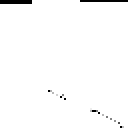

In [55]:
colorview(Gray, warpped[1])

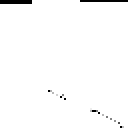

In [56]:
colorview(Gray, warpped[end])

In [53]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) #temp

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 6 
 
 
 10 
 
 
 14 
 
 
 19 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 42 
 
 
 46 
 
 
 50 
 
 
 55 
 
 
 60 
 
 
 64 
 
 
 1 
 
 
 5 
 
 
 10 
 
 
 14 
 
 
 19 
 
 
 23 
 
 
 28 
 
 
 32 
 
 
 36 
 
 
 41 
 
 
 45 
 
 
 50 
 
 
 54 
 
 
 59 
 
 
 63 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 45.4521,261.238 45.4521,257.018 45.4521,252.798 45.4521,248.577 45.4521,244.357 45.4521,244.022 45.4521,243.955 45.4521,236.386 45.4521,228.012 45.4521,223.256 
 45.4521,219.036 45.4521,218.299 45.4521,218.232 45.4521,214.815 45.4521,210.595 45.4521,203.159 45.4521,194.786 42.4523,189.494 38.4091,185.274 37.2353,184.001 
 37.2353,183.934 37.2353,183.867 37.2353,183.8 39.8438,181.053 43.887,176.833 45.4521,172.613 45.4521,168.393 45.4521,166.584 45.4521,166.517 45.4521,159.617 
 45.4521,147.09 45.4521,136.707 45.4521,128.334 45.4521,123.98 45.4521,123.913 47.278,121.97 51.3212,117.75 51.9733,115.271 47.9301,115.204 45.4521,111.922 
 45.4521,103.548 42.5827,93.701 34.4964,81.1742 29.0186,69.9872 29.0186,61.6137 29.0186,55.6518 29.0186,55.5848 32.1488,57.6614 44.2782,65.901 51.8429,71.327 
 43.7565,67.1067 36.4528,61.2788 32.4096,48.752 29.6707,37.565 33.7139,33.3448 37.2353,29.6604 37.2353,29.5934 37.2353,29.5264 37.2353,29.4595 36.9745,29.3925 
 32.9313,29.3255 29.0186,28.9905 29.0186,20.617 29.0186,12.2435 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 49.5604,261.238 51.5499,257.018 53.5394,252.798 53.6036,250.555 53.6036,248.379 53.6036,248.175 53.6036,248.108 50.0097,242.385 46.0307,236.055 47.2501,231.562 
 49.2396,227.342 49.5604,221.463 49.5604,215.265 49.5604,212.31 49.5604,210.134 46.4799,203.159 42.501,194.786 41.4265,189.494 41.3623,185.274 41.3437,184.001 
 41.3437,183.934 41.3437,183.867 41.3437,183.8 42.6686,179.735 44.7223,173.471 46.7366,169.712 48.7261,167.536 49.5604,166.584 49.5604,166.517 48.4694,158.497 
 46.4799,143.926 47.571,132.554 51.5499,124.181 53.6036,119.826 53.6036,119.759 54.5311,118.74 56.5847,116.563 56.0817,114.414 52.0385,112.303 48.7903,108.56 
 46.8008,102.23 43.3539,93.701 37.2571,81.1742 32.4852,70.6465 30.4957,64.3166 30.239,59.805 34.218,59.7381 38.76,61.2873 44.9211,67.4831 48.7634,70.8655 
 44.6561,64.6016 39.791,57.1255 31.7689,44.5988 25.6927,33.7414 29.7359,31.5648 33.2574,29.9241 33.2574,31.9008 33.2574,33.6797 33.2574,33.6127 33.2532,33.1502 
 33.189,26.9522 33.1911,20.7499 35.1806,14.4201 37.1701,8.09027 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 53.6688,261.238 57.6478,257.018 61.6268,252.798 61.7551,252.533 61.7551,252.4 61.7551,252.329 61.7551,252.262 54.5673,248.384 46.6093,244.098 49.0481,239.869 
 53.027,235.649 53.6688,224.628 53.6688,212.299 53.6688,209.805 53.6688,209.672 47.5078,203.159 39.5498,194.786 40.4007,189.494 44.3155,185.274 45.4521,184.001 
 45.4521,183.934 45.4521,183.867 45.4521,183.8 45.4935,178.416 45.5576,170.109 48.0212,166.812 52.0002,166.679 53.6688,166.584 53.6688,166.517 51.4868,157.376 
 47.5078,140.762 49.6898,128.401 57.6478,120.027 61.7551,115.673 61.7551,115.606 61.7841,115.509 61.8483,115.376 60.1901,113.557 56.1469,109.403 52.1286,105.197 
 48.1496,100.911 44.125,93.701 40.0177,81.1742 35.9518,71.3057 31.9728,67.0195 31.4594,63.9583 39.4173,63.8913 45.3713,64.9131 45.5639,69.0653 45.6839,70.404 
 45.5556,62.0965 43.1293,52.9723 31.1281,40.4455 21.7148,29.9177 25.7579,29.7848 29.2794,30.1878 29.2794,34.2082 29.2794,37.833 29.2794,37.766 29.532,36.9079 
 33.4468,24.5789 37.3637,12.5094 41.3427,8.22318 45.3216,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 53.8645,257.219 55.9823,254.976 58.1002,252.734 58

In [41]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) #β=0.1, χ=0, method=CanonHOPM(maxIteration=200))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
 
 3 
 
 
 7 
 
 
 11 
 
 
 16 
 
 
 20 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 41 
 
 
 45 
 
 
 49 
 
 
 54 
 
 
 58 
 
 
 62 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 21.7148,284.952 21.7148,280.189 21.7148,275.426 21.7148,275.199 21.7148,275.124 21.7148,270.663 21.7148,265.9 21.7148,261.137 21.7148,256.374 21.7148,251.611 
 21.7148,246.848 21.7148,242.085 21.7148,237.322 21.7148,232.559 21.7148,227.796 21.7148,223.033 21.7148,218.27 21.7148,213.507 21.7148,208.744 21.7148,203.981 
 21.7148,199.219 21.7148,194.456 21.7148,189.693 21.7148,184.93 21.7148,180.167 21.7148,175.404 21.7148,170.641 21.7148,165.878 21.7148,161.115 21.7148,156.352 
 21.7148,151.589 21.7148,146.826 21.7148,142.063 21.7148,137.3 21.7148,132.537 21.7148,127.774 21.7148,123.011 21.7148,118.248 21.7148,113.485 21.7148,108.722 
 21.7148,103.959 21.7148,99.1963 21.7148,94.4333 21.7148,89.6704 21.7148,84.9074 21.7148,80.1444 21.7148,75.3815 21.7148,70.6185 21.7148,65.8555 21.7148,61.0926 
 21.7148,56.3296 21.7148,51.5666 21.7148,46.8037 21.7148,42.0407 21.7148,37.2778 21.7148,32.5148 21.7148,27.7518 21.7148,22.9889 21.7148,18.2259 21.7148,13.7653 
 21.7148,13.6897 21.7148,13.4629 21.7148,8.69997 21.7148,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 26.3648,284.952 26.3648,280.189 26.3648,275.426 26.3648,275.199 26.3648,275.124 26.3648,270.663 26.3648,265.9 26.3648,261.137 26.3648,256.374 26.3648,251.611 
 26.3648,246.848 26.3648,242.085 26.3648,237.322 26.3648,232.559 26.3648,227.796 26.3648,223.033 26.3648,218.27 26.3648,213.507 26.3648,208.744 26.3648,203.981 
 26.3648,199.219 26.3648,194.456 26.3648,189.693 26.3648,184.93 26.3648,180.167 26.3648,175.404 26.3648,170.641 26.3648,165.878 26.3648,161.115 26.3648,156.352 
 26.3648,151.589 26.3648,146.826 26.3648,142.063 26.3648,137.3 26.3648,132.537 26.3648,127.774 26.3648,123.011 26.3648,118.248 26.3648,113.485 26.3648,108.722 
 26.3648,103.959 26.3648,99.1963 26.3648,94.4333 26.3648,89.6704 26.3648,84.9074 26.3648,80.1444 26.3648,75.3815 26.3648,70.6185 26.3648,65.8555 26.3648,61.0926 
 26.3648,56.3296 26.3648,51.5666 26.3648,46.8037 26.3648,42.0407 26.3648,37.2778 26.3648,32.5148 26.3648,27.7518 26.3648,22.9889 26.3648,18.2259 26.2195,13.7653 
 23.9677,13.6897 21.7886,13.4629 21.7886,8.69997 21.7886,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.0147,284.952 31.0147,280.189 31.0147,275.426 31.0147,275.199 31.0147,275.124 31.0147,270.663 31.0147,265.9 31.0147,261.137 31.0147,256.374 31.0147,251.611 
 31.0147,246.848 31.0147,242.085 31.0147,237.322 31.0147,232.559 31.0147,227.796 31.0147,223.033 31.0147,218.27 31.0147,213.507 31.0147,208.744 31.0147,203.981 
 31.0147,199.219 31.0147,194.456 31.0147,189.693 31.0147,184.93 31.0147,180.167 31.0147,175.404 31.0147,170.641 31.0147,165.878 31.0147,161.115 31.0147,156.352 
 31.0147,151.589 31.0147,146.826 31.0147,142.063 31.0147,137.3 31.0147,132.537 31.0147,127.774 31.0147,123.011 31.0147,118.248 31.0147,113.485 31.0147,108.722 
 31.0147,103.959 31.0147,99.1963 31.0147,94.4333 31.0147,89.6704 31.0147,84.9074 31.0147,80.1444 31.0147,75.3815 31.0147,70.6185 31.0147,65.8555 31.0147,61.0926 
 31.0147,56.3296 31.0147,51.5666 31.0147,46.8037 31.0147,42.0407 31.0147,37.2778 31.0147,32.5148 31.0147,27.7518 31.0147,22.9889 31.0147,18.2259 30.7242,13.7653 
 26.2207,13.6897 21.8624,13.4629 21.8624,8.69997 21.8624,3.93701 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 31.2362,284.952 31.2362,280

In [49]:
displacementfield(meshgrid(d[end])...; xyInv=true, size=(300,300)) #temp

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 6 
 
 
 10 
 
 
 14 
 
 
 19 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 42 
 
 
 46 
 
 
 50 
 
 
 55 
 
 
 60 
 
 
 64 
 
 
 1 
 
 
 6 
 
 
 10 
 
 
 14 
 
 
 19 
 
 
 24 
 
 
 28 
 
 
 32 
 
 
 37 
 
 
 42 
 
 
 46 
 
 
 50 
 
 
 55 
 
 
 60 
 
 
 64 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 52.8519,271.419 48.9281,267.156 45.0043,262.893 41.0805,250.51 37.1568,237.857 29.5623,233.052 21.7148,228.79 24.4994,228.316 28.4232,228.248 28.9295,228.181 
 28.9295,228.113 42.0931,228.045 57.7883,227.978 57.6617,224.527 53.7379,220.264 52.8519,212.753 52.8519,204.295 52.8519,202.062 52.8519,201.994 50.0673,201.926 
 46.1435,201.859 42.2197,193.265 38.2959,180.612 39.4351,176.078 43.3589,176.01 44.8777,173.371 44.8777,169.109 44.8777,162.41 44.8777,153.951 44.8777,150.095 
 44.8777,150.027 44.8777,143.463 44.8777,130.81 44.8777,124.246 44.8777,124.179 46.6498,124.111 50.5736,124.043 49.561,125.735 41.7134,129.863 38.4225,130.742 
 42.3463,126.479 46.2701,120.728 50.1938,112.269 50.3204,102.458 42.4729,89.8045 36.9036,80.805 36.9036,80.7374 38.9288,78.5044 46.7764,70.0462 52.8519,62.5353 
 52.8519,58.2724 52.8519,57.2574 52.8519,69.7756 52.8519,78.2337 52.8519,65.5803 51.8393,54.0095 43.9917,49.7466 36.9036,45.4836 36.9036,41.2207 36.9036,36.9578 
 36.9036,32.6949 36.9036,28.4319 36.9036,24.169 36.9036,19.9061 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 52.9152,275.614 52.8529,271.351 52.7906,267.088 50.8599,260.699 48.8668,254.238 41.397,245.971 33.5494,237.58 32.8462,234.842 32.9085,232.71 32.9165,230.578 
 32.9165,228.446 46.0802,224.582 61.7753,220.386 63.2058,214.471 61.2128,208.144 60.7627,206.56 60.7627,206.359 60.7627,206.257 60.7627,206.189 56.6079,206.122 
 50.7534,206.054 46.2068,198.859 42.283,188.27 44.6678,183.137 50.5223,181.005 51.6052,177.567 49.6745,173.304 48.8648,167.804 48.8648,161.41 48.8648,157.353 
 48.8648,155.221 48.8648,148.724 48.8648,138.135 48.8648,131.638 48.8648,129.506 48.8929,127.374 48.9552,125.242 48.1295,124.004 46.0742,124.002 47.0807,121.553 
 52.9353,115.225 56.0494,109.607 54.1809,105.277 51.0065,98.9286 45.0897,88.3395 40.8907,80.805 40.8907,80.7374 42.9159,79.0371 50.7634,72.6433 56.403,67.6629 
 54.4722,67.5286 52.9152,67.4459 52.9152,67.578 52.9152,66.6468 52.9152,60.1864 52.4008,54.0095 48.4148,49.7466 44.8145,45.4836 44.8145,41.2207 44.6899,36.9578 
 42.7591,32.6949 40.8907,28.4319 40.8907,24.169 40.8907,19.9061 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 52.9785,279.809 56.7777,275.546 60.5769,271.283 60.6392,270.887 60.5769,270.62 53.2316,258.89 45.384,246.37 41.1931,241.368 37.3938,237.171 36.9036,232.975 
 36.9036,228.779 50.0673,221.12 65.7624,212.795 68.7499,204.416 68.6876,196.024 68.6736,200.367 68.6736,208.423 68.6736,210.452 68.6736,210.384 63.1485,210.317 
 55.3633,210.249 50.1938,204.452 46.2701,195.928 49.9005,190.195 57.6858,185.999 58.3327,181.762 54.4712,177.499 52.8519,173.197 52.8519,168.868 52.8519,164.611 
 52.8519,160.415 52.8519,153.985 52.8519,145.46 52.8519,139.03 52.8519,134.833 51.1361,130.637 47.3369,126.441 46.698,122.272 50.4349,118.142 55.739,112.363 
 63.5242,103.971 65.8287,98.4861 58.168,98.2853 51.6926,95.3993 47.7066,86.8745 44.8777,80.805 44.8777,80.7374 46.9029,79.5699 54.7505,75.2403 59.9541,72.7904 
 56.0926,76.7848 52.9785,77.6344 52.9785,65.3805 52.9785,55.0599 52.9785,54.7925 52.9624,54.0095 52.8378,49.7466 52.7253,45.4836 52.7253,41.2207 52.4762,36.9578 
 48.6147,32.6949 44.8777,28.4319 44.8777,24.169 44.8777,19.9061 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.6; stroke-opacity:1; fill:none" points="
 60.6362,275.885 62.6915,273.62 64.7468,2